### Задание №2.
Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог).

- По образцу урока загрузим данные новостей, перепишем код предобработки текста и обучения LDA модели:

In [1]:
import numpy as np
import pandas as pd

In [2]:
news = pd.read_csv("articles.csv")

In [3]:
users = pd.read_csv("users_articles.csv")

In [4]:
# предобработка текстов
import re
import numpy as np
from gensim.corpora.dictionary import Dictionary
from razdel import tokenize
import pymorphy2

from nltk.corpus import stopwords

In [5]:
stopword_ru = stopwords.words('russian')

with open('stopwords.txt', encoding='UTF-8') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
    
stopword_ru += additional_stopwords

In [6]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    text = re.sub('n', ' ', text)
    
    return text

cache = {}
morph = pymorphy2.MorphAnalyzer()

def lemmatization(text):    
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист лемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w) > 1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords = [i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [7]:
%%time
from tqdm import tqdm
tqdm.pandas()

news['title'] = news['title'].progress_apply(lambda x: clean_text(x))

  0%|                                                                                        | 0/27000 [00:00<?, ?it/s]<ipython-input-6-898b573b2830>:14: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
100%|███████████████████████████████████████████████████████████████████████████| 27000/27000 [00:42<00:00, 628.14it/s]


Wall time: 43.1 s


In [8]:
%%time

news['title'] = news['title'].progress_apply(lambda x: lemmatization(x))

100%|████████████████████████████████████████████████████████████████████████████| 27000/27000 [05:21<00:00, 83.92it/s]

Wall time: 5min 21s


In [9]:
# сформируем список наших текстов
texts = list(news['title'].values)

# Создадим корпус из списка с текстами
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [10]:
N_topic = 20

In [11]:
%%time
from gensim.models import LdaModel

# Обучаем модель на корпусе с 5ю проходами
lda = LdaModel(common_corpus, num_topics=N_topic, id2word=common_dictionary, passes=5)

Wall time: 3min 15s


In [12]:
from gensim.test.utils import datapath

temp_file = datapath("model.lda")

In [13]:
# Сохраняем модель на диск
lda.save(temp_file)

In [14]:
# Загружаем обученную модель с диска
lda = LdaModel.load(temp_file)

In [15]:
def get_lda_vector(lda, text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]

    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(N_topic):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [16]:
%%time
topic_matrix = pd.DataFrame([get_lda_vector(lda, text) for text in news['title'].values])
topic_matrix.columns = [f'topic_{i}' for i in range(N_topic)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+[f'topic_{i}' for i in range(N_topic)]]

Wall time: 30.6 s


- Далее дополним функцию `get_user_embedding` возможностью выбора метода получения вектора описания пользователя, в том числе методом __tfidf__:

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer

import matplotlib.pyplot as plt
import itertools

In [18]:
def get_user_embedding(user_articles_list, doc_dict, stat:{'mean', 'median', 'max', 'idf_mean'}='mean'):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    # print(user_vector)
    if stat != 'idf_mean':
        user_vector = eval(f'np.{stat}(user_vector, 0)')
    else:
        transformer = TfidfTransformer()
        user_vector = np.mean(transformer.fit_transform(user_vector).toarray(), 0)
    return user_vector

In [19]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [20]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[[f'topic_{i}' for i in range(N_topic)]].values))

- Получим матрицу пользователь-тема усреднением векторов описания пользователей с помощью `np.median`:

In [21]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict, 'median'))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]

In [22]:
target = pd.read_csv("users_churn.csv")

In [23]:
X = pd.merge(user_embeddings, target, 'left')

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X['churn'], random_state=0)

- Обучим модель логистической регрессии, посчитаем метрики, посмотрим матрицу ошибок:

In [25]:
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

LogisticRegression()

In [26]:
preds = logreg.predict_proba(X_test)[:, 1]

In [27]:
from sklearn.metrics import (f1_score, roc_auc_score, precision_score,
                             classification_report, precision_recall_curve, confusion_matrix)

In [28]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.31713334053493947, F-Score=0.755, Precision=0.726, Recall=0.788


Confusion matrix, without normalization
[[1682   73]
 [  53  192]]


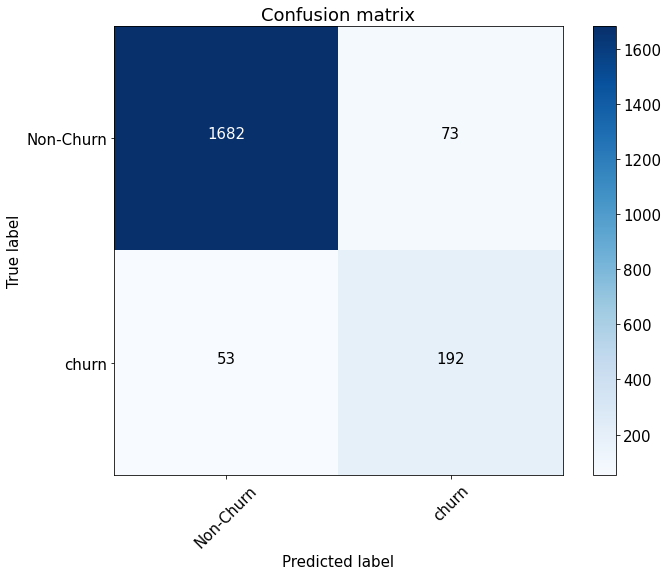

In [29]:
font = {'size' : 15}
plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds > thresholds[ix])

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.show()

In [30]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.9689121460550031

- Добавим значения метрик в сводную таблицу:

In [31]:
pivot_metric_table = []

In [32]:
pivot_metric_table.append((fscore[ix], precision[ix], recall[ix], roc_auc))

___

### Задание №3.
Повторить п.2, но используя уже не медиану, а max.

- Аналогично заданию №2 произведем обучение модели и подсчет метрик, заменив значение аргумента `stat` функции `get_user_embedding` на `max`:

In [33]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict, 'max'))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]

In [34]:
X = pd.merge(user_embeddings, target, 'left')

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X['churn'], random_state=0)

In [36]:
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

LogisticRegression()

In [37]:
preds = logreg.predict_proba(X_test)[:, 1]

In [38]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.3533421045883026, F-Score=0.800, Precision=0.808, Recall=0.792


Confusion matrix, without normalization
[[1709   46]
 [  52  193]]


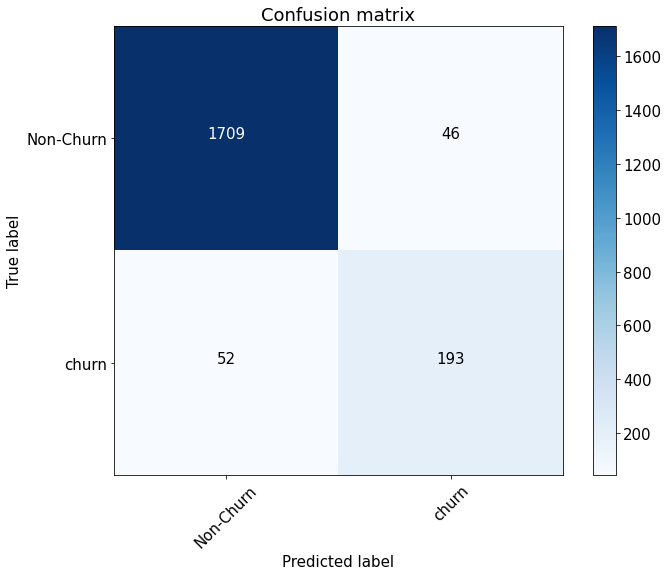

In [39]:
cnf_matrix = confusion_matrix(y_test, preds > thresholds[ix])

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.show()

In [40]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.9726681783824641

In [41]:
pivot_metric_table.append((fscore[ix], precision[ix], recall[ix], roc_auc))

___

### Задание №4.
Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (взяв список новостей пользователя).

- Тоже самое произведем в отношении `idf_mean`:

In [42]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict, 'idf_mean'))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]

In [43]:
X = pd.merge(user_embeddings, target, 'left')

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X['churn'], random_state=0)

In [45]:
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

LogisticRegression()

In [46]:
preds = logreg.predict_proba(X_test)[:, 1]

In [47]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.38113296908369493, F-Score=0.902, Precision=0.899, Recall=0.906


Confusion matrix, without normalization
[[1730   25]
 [  24  221]]


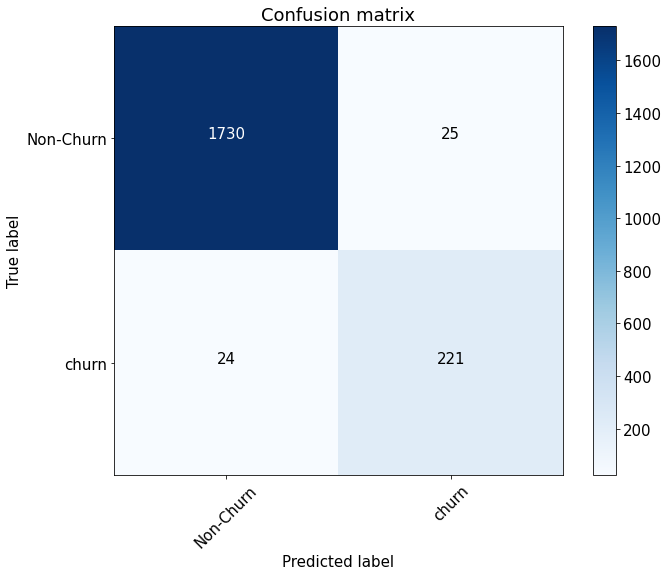

In [48]:
cnf_matrix = confusion_matrix(y_test, preds > thresholds[ix])

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [49]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.9926391069248213

In [50]:
pivot_metric_table.append((fscore[ix], precision[ix], recall[ix], roc_auc))

___

### Задание №5.
Сформировать на выходе единую таблицу, сравнивающую качество 2/3 разных метода получения эмбедингов пользователей: median, max, idf_mean по метрикам roc_auc, precision, recall, f_score.

Соберем DataFrame сводной таблицы:

In [51]:
pivot_metric_table = pd.DataFrame(pivot_metric_table)
pivot_metric_table.columns = ['F_score', 'Precision', 'Recall', 'ROC_AUC_score']
pivot_metric_table['Averaging_method'] = ['median', 'max', 'idf_mean']
pivot_metric_table.set_index('Averaging_method', inplace=True)

In [52]:
pivot_metric_table

,F_score,Precision,Recall,ROC_AUC_score
Averaging_method,,,,
median,0.755382,0.725564,0.787755,0.968912
max,0.800000,0.808333,0.791837,0.972668
idf_mean,0.902439,0.898785,0.906122,0.992639


___

### Задание №6.
Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных.

Как можно видеть из сводной таблицы с хорошим отрывом по F_score лидирует метод со взешенным усреденением профилей пользователей с помощью __tfidf__. Вероятно, веса idf при профилировании таким образом делают акцент на темах, которые в большей степени относятся рассматриваемому пользователю, и размывают его(акцент) при более общих темах, которые присущи большим массам.